In [1]:
pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.15.0
GPU available: True


In [2]:
import os
print(f"Current directory: {os.getcwd()}")

Current directory: /Users/bonsitukebeto/Documents/GitHub/gaming-sentiment-analysis/notebooks


In [3]:
# Load embeddings
X_train = np.load('data/embeddings/train_embeddings.npy')
X_val = np.load('data/embeddings/val_embeddings.npy')
X_test = np.load('data/embeddings/test_embeddings.npy')

# Load labels
y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
y_test = np.load('data/processed/y_test.npy')

# Load class weights
with open('data/processed/class_weights.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")
print(f"\nClass weights: {class_weight_dict}")

Train: (79998, 384), (79998,)
Val:   (10000, 384), (10000,)
Test:  (10000, 384), (10000,)

Class weights: {0: 2.2781717214865442, 1: 4.0208082026538, 2: 0.4324613613142829}


## MLP Model

- Input: 384-dim embeddings
- Hidden layers: 256 → 128 → 64
- BatchNormalization + Dropout (0.2-0.3)
- Output: 3 classes (softmax)

In [4]:
def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(384,)),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(3, activation='softmax')
    ], name='MLP_Baseline')
    
    return model

mlp_model = build_mlp()
mlp_model.summary()

2025-11-24 00:35:00.102427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-24 00:35:00.104575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-24 00:35:00.105673: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-24 00:35:00.106316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 00:35:00.106845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "MLP_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               98560     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)              

## Compile Model 
- Optimizer: Adam (adaptive learning rate)
- Loss: Sparse categorical crossentropy with class weights
- Metrics: Accuracy

In [7]:
mlp_model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Callbacks

In [8]:
# Create models directory
Path('models').mkdir(exist_ok=True)

callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'models/mlp_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]


## Train Model

In [9]:
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/50


2025-11-24 01:10:07.765699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 32s 11ms/step - loss: 0.8643 - accuracy: 0.6579 - val_loss: 0.7158 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 2/50
2500/2500 [==============================] - 29s 11ms/step - loss: 0.8064 - accuracy: 0.6909 - val_loss: 0.6598 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 3/50
2500/2500 [==============================] - 28s 11ms/step - loss: 0.8041 - accuracy: 0.6962 - val_loss: 0.6885 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 4/50
2500/2500 [==============================] - 28s 11ms/step - loss: 0.8044 - accuracy: 0.6958 - val_loss: 0.7235 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 5/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.8051 - accuracy: 0.6971 - val_loss: 0.7542 - val_accuracy: 0.6805 - lr: 0.0010
Epoch 6/50
2500/2500 [==============================] - 29s 12ms/step - loss: 0.8041 - accuracy: 0.6978 - val_loss: 0.6926 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 7/50
2498/2500 [============================>.] - E

## Training History Visualization

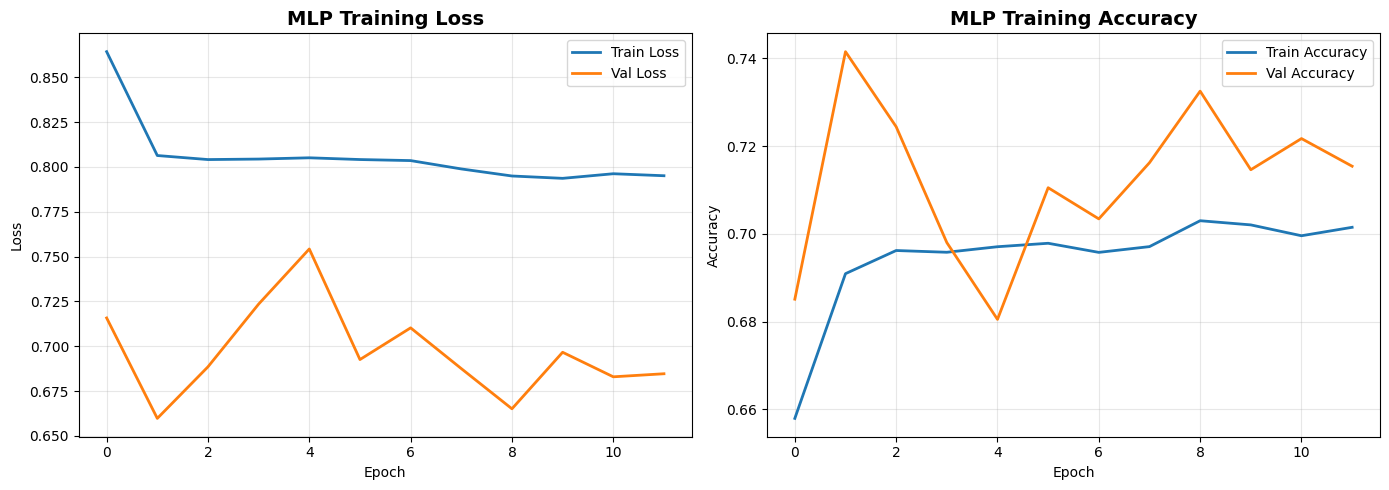

  Train Loss: 0.7951
  Train Acc:  0.7015
  Val Loss:   0.6847
  Val Acc:    0.7154


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('MLP Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('MLP Training Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/mlp_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Train Acc:  {history.history['accuracy'][-1]:.4f}")
print(f"  Val Loss:   {history.history['val_loss'][-1]:.4f}")
print(f"  Val Acc:    {history.history['val_accuracy'][-1]:.4f}")

## Evaluate on Test Set

In [11]:
test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Get predictions
y_pred_probs = mlp_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

Test Loss:     0.6620
Test Accuracy: 0.7435 (74.35%)


## Classification Report

In [12]:
class_names = ['Negative', 'Neutral', 'Positive']

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5184    0.7122    0.6001      1463
     Neutral     0.2205    0.4198    0.2892       829
    Positive     0.9428    0.7843    0.8562      7708

    accuracy                         0.7435     10000
   macro avg     0.5606    0.6388    0.5818     10000
weighted avg     0.8208    0.7435    0.7717     10000



## Confusion Matrix

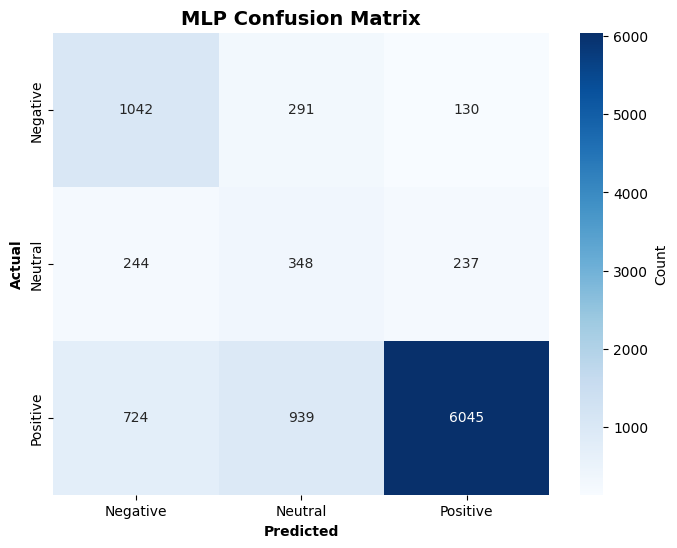

In [13]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
ax.set_title('MLP Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontweight='bold')
ax.set_ylabel('Actual', fontweight='bold')

plt.savefig('results/figures/mlp_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Per-Class Performance

   Class  Precision   Recall  F1-Score  Support
Negative   0.518408 0.712235  0.600058     1463
 Neutral   0.220532 0.419783  0.289157      829
Positive   0.942764 0.784250  0.856232     7708


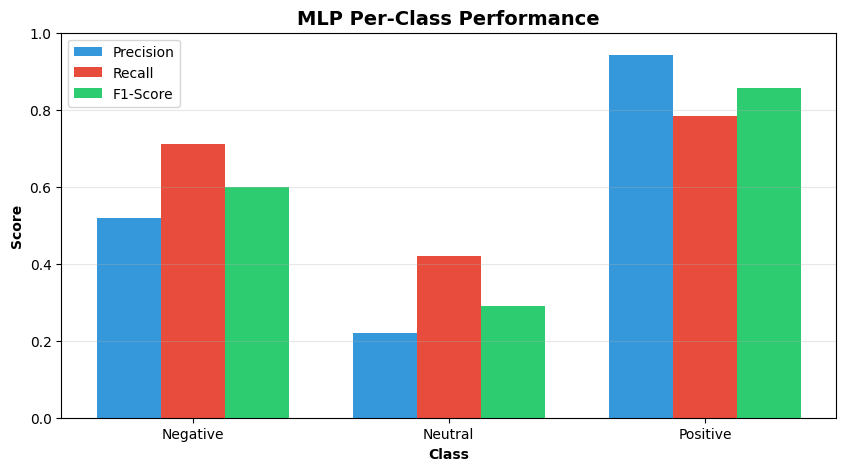

In [14]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# performance dataframe
perf_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(perf_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', color='#3498db')
ax.bar(x, recall, width, label='Recall', color='#e74c3c')
ax.bar(x + width, f1, width, label='F1-Score', color='#2ecc71')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('MLP Per-Class Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.savefig('results/figures/mlp_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Error Analysis

In [15]:
# Find misclassified examples
errors = y_test != y_pred
error_indices = np.where(errors)[0]

print(f"Total errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")

# Count errors by true class
for i, class_name in enumerate(class_names):
    class_mask = y_test == i
    class_errors = np.sum(errors & class_mask)
    class_total = np.sum(class_mask)
    print(f"  {class_name}: {class_errors}/{class_total} ({class_errors/class_total*100:.1f}%)")

Total errors: 2565 / 10000 (25.65%)
  Negative: 421/1463 (28.8%)
  Neutral: 481/829 (58.0%)
  Positive: 1663/7708 (21.6%)


## Save Results

In [16]:
results = {
    'model': 'MLP',
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1': f1.tolist(),
    'confusion_matrix': cm.tolist(),
    'epochs_trained': len(history.history['loss']),
    'parameters': mlp_model.count_params()
}

import json
with open('results/metrics/mlp_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save predictions
np.save('results/metrics/mlp_predictions.npy', y_pred)
np.save('results/metrics/mlp_probabilities.npy', y_pred_probs)